In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
import warnings
from mplsoccer.pitch import Pitch
import seaborn as sns
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
match_html_path = r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 2-0 Tottenham - Premier League 2025_2026 Live.html"
fotmob_matchId = 4813622

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)
dfp['shortName'] = dfp['name'].apply(get_short_name)

In [3]:
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")

In [4]:
df['teamName'] = df['teamId'].map(teams_dict)
team_names = list(teams_dict.values())
opposition_dict = {team_names[i]: team_names[1-i] for i in range(len(team_names))}
df['oppositionTeamName'] = df['teamName'].map(opposition_dict)

In [5]:
df['x'] = df['x']*1.2
df['y'] = df['y']*0.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*0.8
df['goalMouthY'] = df['goalMouthY']*0.8

In [6]:
columns_to_drop = ['height', 'weight', 'age', 'isManOfTheMatch', 'field', 'stats', 
                   'subbedInPlayerId', 'subbedOutPeriod', 
                   'subbedOutExpandedMinute', 'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId', 
                   'teamId']
dfp.drop(columns=columns_to_drop, inplace=True)

In [7]:
df = df.merge(dfp, on='playerId', how='left')

In [8]:
df.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'relatedEventId', 'relatedPlayerId', 'goalMouthZ', 'goalMouthY',
       'isShot', 'blockedX', 'blockedY', 'cardType', 'isGoal', 'teamName',
       'oppositionTeamName', 'shirtNo', 'name', 'position', 'isFirstEleven',
       'shortName'],
      dtype='object')

In [9]:
df

,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,...,blockedY,cardType,isGoal,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,2.897126e+09,3,0,0.0,32,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Tottenham,NaN,NaN,NaN,NaN,NaN
1,2.897126e+09,3,0,0.0,30,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Tottenham,Man Utd,NaN,NaN,NaN,NaN,NaN
2,2.897126e+09,4,0,0.0,30,60.24,39.92,0,NaN,NaN,...,NaN,NaN,NaN,Tottenham,Man Utd,7.0,Xavi Simons,FWL,True,X. Simons
3,2.897126e+09,5,0,5.0,30,42.48,36.88,0,NaN,NaN,...,NaN,NaN,NaN,Tottenham,Man Utd,1.0,Guglielmo Vicario,GK,True,G. Vicario
4,2.897126e+09,4,0,9.0,32,10.20,29.04,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Tottenham,5.0,Harry Maguire,DC,True,H. Maguire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,2.897226e+09,982,95,15.0,32,0.00,0.00,101,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Tottenham,NaN,NaN,NaN,NaN,NaN
1570,2.897226e+09,705,0,0.0,30,0.00,0.00,11,NaN,NaN,...,NaN,NaN,NaN,Tottenham,Man Utd,NaN,NaN,NaN,NaN,NaN
1571,2.897227e+09,983,0,0.0,32,0.00,0.00,11,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Tottenham,NaN,NaN,NaN,NaN,NaN
1572,2.897103e+09,2,0,0.0,30,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Tottenham,Man Utd,NaN,NaN,NaN,NaN,NaN


In [10]:
dfp

,playerId,shirtNo,name,position,isFirstEleven,shortName
0,402184,31,Senne Lammens,GK,True,S. Lammens
1,353418,2,Diogo Dalot,DR,True,D. Dalot
2,340105,6,Lisandro Martínez,DC,True,L. Martínez
3,99487,5,Harry Maguire,DC,True,H. Maguire
4,118244,23,Luke Shaw,DL,True,L. Shaw
5,88526,18,Casemiro,DMC,True,Casemiro
6,460260,37,Kobbie Mainoo,DMC,True,K. Mainoo
7,386634,16,Amad Diallo,AMR,True,A. Diallo
8,123761,8,Bruno Fernandes,AMC,True,B. Fernandes
9,353377,19,Bryan Mbeumo,AML,True,B. Mbeumo


In [11]:
df = df[
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['endX'].notna()) & 
    (df['endY'].notna())) | 
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['goalMouthY'].notna()))
]

In [12]:
df=df.reset_index()

In [13]:
df

,index,id,eventId,minute,second,teamId,x,y,expandedMinute,period,...,blockedY,cardType,isGoal,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,2,2.897126e+09,4,0,0.0,30,60.24,39.92,0,NaN,...,NaN,NaN,NaN,Tottenham,Man Utd,7.0,Xavi Simons,FWL,True,X. Simons
1,3,2.897126e+09,5,0,5.0,30,42.48,36.88,0,NaN,...,NaN,NaN,NaN,Tottenham,Man Utd,1.0,Guglielmo Vicario,GK,True,G. Vicario
2,6,2.897126e+09,5,0,9.0,32,10.20,29.04,0,NaN,...,NaN,NaN,NaN,Man Utd,Tottenham,5.0,Harry Maguire,DC,True,H. Maguire
3,9,2.897126e+09,7,0,13.0,32,2.40,25.52,0,NaN,...,NaN,NaN,NaN,Man Utd,Tottenham,31.0,Senne Lammens,GK,True,S. Lammens
4,10,2.897127e+09,8,0,17.0,32,15.96,52.64,0,NaN,...,NaN,NaN,NaN,Man Utd,Tottenham,6.0,Lisandro Martínez,DC,True,L. Martínez
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,1560,2.897225e+09,977,94,57.0,32,30.12,48.72,100,NaN,...,NaN,NaN,NaN,Man Utd,Tottenham,25.0,Manuel Ugarte,Sub,NaN,M. Ugarte
1125,1562,2.897227e+09,985,94,59.0,32,26.52,59.28,100,NaN,...,NaN,NaN,NaN,Man Utd,Tottenham,3.0,Noussair Mazraoui,Sub,NaN,N. Mazraoui
1126,1563,2.897225e+09,979,95,1.0,32,92.16,55.52,101,NaN,...,NaN,NaN,NaN,Man Utd,Tottenham,16.0,Amad Diallo,AMR,True,A. Diallo
1127,1564,2.897225e+09,980,95,2.0,32,95.88,59.76,101,NaN,...,NaN,NaN,NaN,Man Utd,Tottenham,8.0,Bruno Fernandes,AMC,True,B. Fernandes


In [14]:
df=df[["minute","second","x","y","endX","endY","teamName","shirtNo","position","shortName","goalMouthY","isShot","isGoal"]]

In [15]:
df

,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,0,0.0,60.24,39.92,28.68,35.60,Tottenham,7.0,FWL,X. Simons,NaN,NaN,NaN
1,0,5.0,42.48,36.88,109.80,50.96,Tottenham,1.0,GK,G. Vicario,NaN,NaN,NaN
2,0,9.0,10.20,29.04,21.60,26.00,Man Utd,5.0,DC,H. Maguire,NaN,NaN,NaN
3,0,13.0,2.40,25.52,10.92,42.00,Man Utd,31.0,GK,S. Lammens,NaN,NaN,NaN
4,0,17.0,15.96,52.64,21.24,75.92,Man Utd,6.0,DC,L. Martínez,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,94,57.0,30.12,48.72,26.88,66.40,Man Utd,25.0,Sub,M. Ugarte,NaN,NaN,NaN
1125,94,59.0,26.52,59.28,47.40,60.00,Man Utd,3.0,Sub,N. Mazraoui,NaN,NaN,NaN
1126,95,1.0,92.16,55.52,95.04,60.96,Man Utd,16.0,AMR,A. Diallo,NaN,NaN,NaN
1127,95,2.0,95.88,59.76,108.12,38.88,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN


In [16]:
df.to_csv('players.csv', index=False)

In [17]:
df.shortName.unique()

array(['X. Simons', 'G. Vicario', 'H. Maguire', 'S. Lammens',
       'L. Martínez', 'L. Shaw', 'B. Mbeumo', 'A. Diallo', 'B. Fernandes',
       'M. v. de Ven', 'Casemiro', 'D. Dalot', 'D. Udogie', 'P. M. Sarr',
       'J. Palhinha', 'C. Romero', 'C. Gallagher', 'M. Cunha',
       'K. Mainoo', 'A. Gray', 'D. Solanke', 'W. Odobert', 'R. Dragusin',
       'Souza', 'R. K. Muani', 'M. Tel', 'Y. Bissouma', 'N. Mazraoui',
       'M. Ugarte', 'J. Zirkzee', 'T. Fletcher', 'B. Sesko'], dtype=object)

In [18]:
#Bruno Data
df_8=df[df["shortName"]=="B. Fernandes"].reset_index()
df_8

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,9,0,33.0,93.60,42.32,104.40,53.12,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
1,47,4,47.0,32.52,2.16,22.92,8.64,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
2,49,4,50.0,33.12,2.16,41.52,13.28,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
3,51,4,57.0,36.36,31.20,39.12,72.72,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
4,58,5,18.0,79.80,49.04,83.28,67.76,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,1098,93,27.0,74.04,63.44,52.80,58.56,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
74,1106,93,58.0,20.52,2.88,28.56,7.68,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
75,1108,94,2.0,40.08,2.16,54.48,11.84,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN
76,1110,94,4.0,48.00,10.56,70.32,9.68,Man Utd,8.0,AMC,B. Fernandes,NaN,NaN,NaN


In [19]:
#Mainoo Data
df_37=df[df["shortName"]=="K. Mainoo"].reset_index()
df_37

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,56,5,12.0,66.96,19.44,70.08,18.00,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
1,57,5,15.0,69.72,24.00,74.88,40.16,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
2,63,5,26.0,77.28,55.92,73.56,49.20,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
3,68,5,44.0,83.04,40.32,77.04,44.00,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
4,88,6,54.0,43.08,52.08,35.88,39.68,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,1020,88,3.0,69.84,71.36,59.28,60.32,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
83,1024,88,9.0,65.76,73.76,58.80,62.72,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
84,1035,89,9.0,43.32,67.44,46.20,73.92,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN
85,1056,90,25.0,86.16,56.72,108.60,63.20,Man Utd,37.0,DMC,K. Mainoo,NaN,NaN,NaN


In [20]:
#Mbeumo Data
df_19=df[df["shortName"]=="B. Mbeumo"].reset_index()
df_19

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,6,0,22.0,39.60,75.20,22.08,71.04,Man Utd,19.0,AML,B. Mbeumo,NaN,NaN,NaN
1,10,0,34.0,109.20,54.96,NaN,NaN,Man Utd,19.0,AML,B. Mbeumo,45.84,True,NaN
2,27,2,9.0,91.56,74.48,107.52,30.80,Man Utd,19.0,AML,B. Mbeumo,NaN,NaN,NaN
3,60,5,21.0,89.64,61.28,82.68,60.48,Man Utd,19.0,AML,B. Mbeumo,NaN,NaN,NaN
4,62,5,24.0,87.48,54.32,79.08,55.92,Man Utd,19.0,AML,B. Mbeumo,NaN,NaN,NaN
5,94,7,19.0,67.68,59.12,76.68,68.48,Man Utd,19.0,AML,B. Mbeumo,NaN,NaN,NaN
6,105,8,1.0,71.40,68.16,71.76,77.76,Man Utd,19.0,AML,B. Mbeumo,NaN,NaN,NaN
7,138,9,58.0,90.12,54.96,88.80,69.84,Man Utd,19.0,AML,B. Mbeumo,NaN,NaN,NaN
8,307,22,19.0,81.12,22.16,94.20,13.20,Man Utd,19.0,AML,B. Mbeumo,NaN,NaN,NaN
9,329,24,25.0,85.08,62.48,78.24,57.12,Man Utd,19.0,AML,B. Mbeumo,NaN,NaN,NaN


In [21]:
#Dalot Data
df_2=df[df["shortName"]=="D. Dalot"].reset_index()
df_2

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,16,1,30.0,47.16,21.12,36.60,27.60,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN
1,20,1,46.0,22.08,9.92,25.80,13.76,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN
2,41,4,39.0,7.20,0.00,33.72,14.48,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN
3,48,4,48.0,22.92,8.64,33.12,2.16,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN
4,54,5,7.0,32.76,19.20,53.16,3.20,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,1075,92,1.0,66.00,20.00,83.28,11.76,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN
67,1079,92,15.0,88.44,40.64,82.56,45.44,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN
68,1093,92,57.0,77.28,21.36,84.00,5.52,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN
69,1095,93,1.0,71.40,18.96,65.04,35.28,Man Utd,2.0,DR,D. Dalot,NaN,NaN,NaN


C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_5172\92792465.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


78


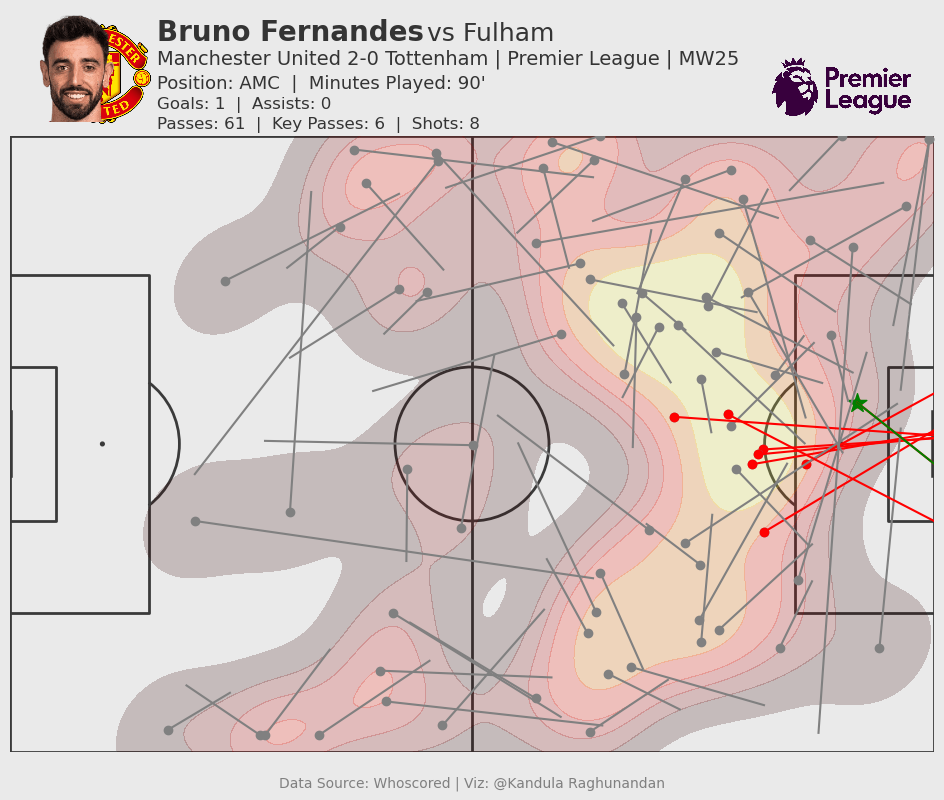

In [28]:
#Bruno Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_8, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="B. Fernandes":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="B. Fernandes") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    #if (df["isGoal"][x]==True):
        #plt.scatter(df["x"][x],df["y"][x],color="Green",marker="^",s=200)
        #plt.scatter(df["x"][1068],df["y"][1068],color="Green",marker="^",s=200)
        #plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="Green")
        #plt.plot((df["x"][1068],df["endX"][1068]),(df["y"][1068],df["endY"][1068]),color="Green")
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="B. Fernandes"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Bruno Fernandes", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.475,1,"vs Fulham", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Manchester United 2-0 Tottenham | Premier League | MW25", fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: AMC  |  Minutes Played: 90'", fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Bruno Fernandes.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 1  |  Assists: 0", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 61  |  Key Passes: 6  |  Shots: 8", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 2-0 Tottenham - Premier League 2025_2026 Live_files\New folder\Bruno.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_5172\691843053.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


87


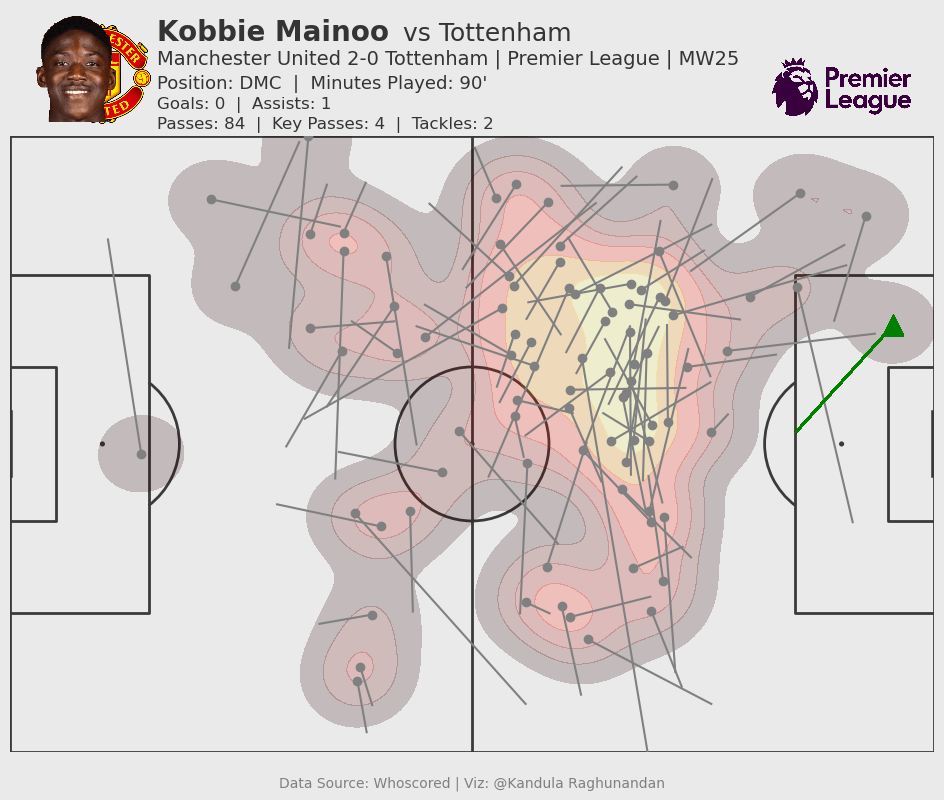

In [33]:
#Mainoo Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_37, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="K. Mainoo":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="K. Mainoo") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    if (df["isGoal"][421]==True):
        plt.scatter(df["x"][420],df["y"][420],color="Green",marker="^",s=200)
        plt.plot((df["x"][420],df["endX"][420]),(df["y"][420],df["endY"][420]),color="Green")
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="K. Mainoo"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Kobbie Mainoo", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.455,1,"vs Tottenham", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Manchester United 2-0 Tottenham | Premier League | MW25", fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: DMC  |  Minutes Played: 90'", fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Mainoo.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 0  |  Assists: 1 ", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 84  |  Key Passes: 4  |  Tackles: 2", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 2-0 Tottenham - Premier League 2025_2026 Live_files\New folder\Mainoo.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_5172\820799520.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


41


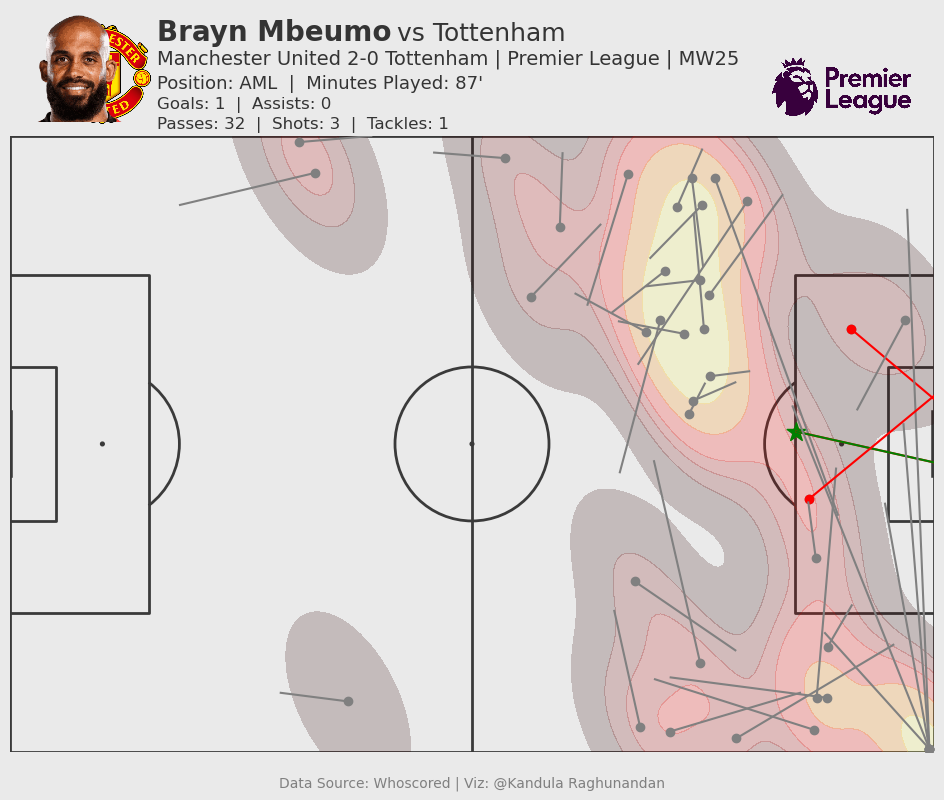

In [34]:
#Mbeumo Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_19, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="B. Mbeumo":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="B. Mbeumo") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    #if (df["isGoal"][821]==True):
        #plt.scatter(df["x"][820],df["y"][820],color="#808080",marker="^",s=200)
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="B. Mbeumo"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Brayn Mbeumo", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.45,1,"vs Tottenham", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Manchester United 2-0 Tottenham | Premier League | MW25", fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: AML  |  Minutes Played: 87'", fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Mbeumo.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 1  |  Assists: 0", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 32  |  Shots: 3  |  Tackles: 1", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 2-0 Tottenham - Premier League 2025_2026 Live_files\New folder\Mbeumo.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_5172\1945970895.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


71


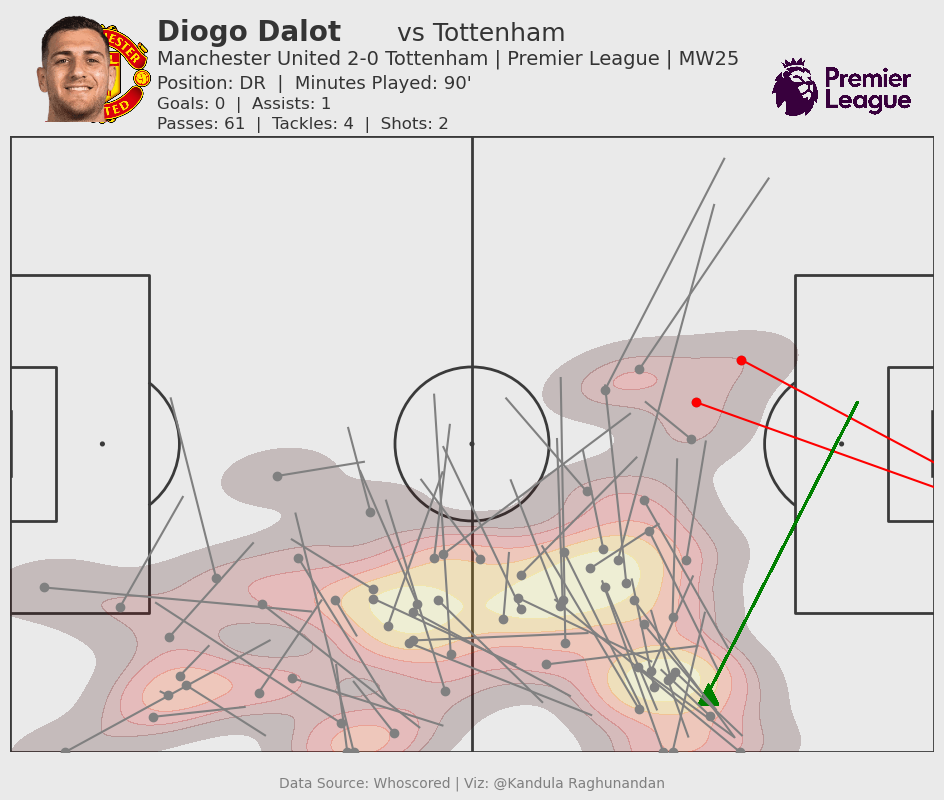

In [36]:
#Dalot Vis
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df_2, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="D. Dalot":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="D. Dalot") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    if (df["isGoal"][939]==True):
        plt.scatter(df["x"][938],df["y"][938],color="Green",marker="^",s=200)
        plt.plot((df["x"][938],df["endX"][938]),(df["y"][938],df["endY"][938]),color="Green")
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="D. Dalot"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Diogo Dalot", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.45,1,"vs Tottenham", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Manchester United 2-0 Tottenham | Premier League | MW25", fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: DR  |  Minutes Played: 90'", fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Dalot.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 0  |  Assists: 1", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 61  |  Tackles: 4  |  Shots: 2", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester United 2-0 Tottenham - Premier League 2025_2026 Live_files\New folder\Dalot.jpg",bbox_inches='tight')